# My mood in 2019 (According to Spotify)
## To get the data: 
## https://towardsdatascience.com/get-your-spotify-streaming-history-with-python-d5a208bbcbd3

In [1]:
from collections import namedtuple
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='georgia')
sns.set_style("ticks")

In [2]:
df = pd.read_csv('final.csv', index_col = 0)
df.shape

(24392, 24)

In [3]:
#tracks playing time
df['secPlayed'] = df['msPlayed'] / 1000
df = df[df.columns[:-1].insert(4, df.columns[-1])] #moving seconds column to proper place
df = df[df.secPlayed > 60] #removing songs that were played for less than 60 secs
df.shape

(16388, 25)

In [4]:
df.head()

,name,endTime,artistName,trackName,secPlayed,msPlayed,datetime,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1,I Shall Love 2,2019-01-26 07:49,Julia Holter,I Shall Love 2,240.26,240260,2019-01-26 07:49:00,0.396,0.378,0.0,...,0.1190,0.131,80.162,audio_features,4VxGlr9PawFDaThx20USnS,spotify:track:4VxGlr9PawFDaThx20USnS,https://api.spotify.com/v1/tracks/4VxGlr9PawFD...,https://api.spotify.com/v1/audio-analysis/4VxG...,318547.0,4.0
2,Top of the Hill,2019-01-26 07:53,Tom Waits,Top of the Hill,239.68,239680,2019-01-26 07:53:00,0.409,0.951,2.0,...,0.8410,0.580,78.174,audio_features,40LQFOzW6rTy58AY8QxIIQ,spotify:track:40LQFOzW6rTy58AY8QxIIQ,https://api.spotify.com/v1/tracks/40LQFOzW6rTy...,https://api.spotify.com/v1/audio-analysis/40LQ...,239680.0,4.0
3,Hoist That Rag,2019-01-26 07:57,Tom Waits,Hoist That Rag,248.28,248280,2019-01-26 07:57:00,0.411,0.832,9.0,...,0.1890,0.674,103.523,audio_features,4H3K3jbAgNoDIbVcU6c6kg,spotify:track:4H3K3jbAgNoDIbVcU6c6kg,https://api.spotify.com/v1/tracks/4H3K3jbAgNoD...,https://api.spotify.com/v1/audio-analysis/4H3K...,248280.0,4.0
4,Sins of My Father,2019-01-26 09:03,Tom Waits,Sins of My Father,637.32,637320,2019-01-26 09:03:00,0.609,0.394,10.0,...,0.0995,0.304,107.658,audio_features,7vx3AX4sL3KyAcBkrIs3wB,spotify:track:7vx3AX4sL3KyAcBkrIs3wB,https://api.spotify.com/v1/tracks/7vx3AX4sL3Ky...,https://api.spotify.com/v1/audio-analysis/7vx3...,637320.0,4.0
5,Shake It,2019-01-26 09:33,Tom Waits,Shake It,118.32,118320,2019-01-26 09:33:00,0.647,0.800,7.0,...,0.3340,0.942,160.078,audio_features,0cqRj7pUJDkTCEsJkx8snD,spotify:track:0cqRj7pUJDkTCEsJkx8snD,https://api.spotify.com/v1/tracks/0cqRj7pUJDkT...,https://api.spotify.com/v1/audio-analysis/0cqR...,219200.0,4.0


In [5]:
#identifying the month
df['month'] = df.endTime.str.split('-').apply(lambda x: (x[0], x[1]))

In [6]:
#listing months and features
months = list(set(df.month.values))
months.sort()
features = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'valence']

In [7]:
#standardizing features (we're interested not in their absolute value, but in how each changed over time)
for feature in features:
    df[f'{feature}_zscore'] = ( df[feature] - df[feature].mean() ) / df[feature].std()

In [8]:
#making sure we standardized correctly: mean is 0 and std is 1
df[[feature + '_zscore' for feature in features]].describe().loc['mean':'std'].T

,mean,std
danceability_zscore,2.852111e-17,1.0
energy_zscore,-2.875969e-14,1.0
speechiness_zscore,-9.706186e-16,1.0
instrumentalness_zscore,-1.434429e-14,1.0
valence_zscore,1.058462e-14,1.0


In [9]:
#features averages by month
Month = namedtuple('Month', features)
avg_features_months = []
for month in months:
    df_month = df[df['month'] == month]
    avg_features = df_month.describe().loc['mean'][[feature + '_zscore' for feature in features]]
    month = Month(*avg_features)
    avg_features_months.append(month)

In [14]:
#labelling months
month_labels = [f'{month[1]}/{month[0]}' for month in months]
month_labels_short = [m[:3]+m[-2:] for m in month_labels]

In [56]:
def features_sns(features):
    fig, ax = plt.subplots(figsize = (25,10))
    x = [x for x in range(13)]

    for feature in features:
        y = [getattr(month, feature) for month in avg_features_months]
        fig = sns.lineplot(x,y, label=feature, linewidth=6, alpha=.7, marker='o', markersize=15)
    
    ax.set_xticks([x for x in range(13)])
    ax.set_xticklabels(labels=month_labels_short, rotation=45, ha='right', size=30)

    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(30) 

    leg = ax.legend(loc = 'upper left', bbox_to_anchor=(1,1.03), prop={'size': 30})

    # get the individual lines inside legend and set line width
    for line in leg.get_lines():
        line.set_linewidth(10)
    
    ax.set_title('My mood in 2019 (According to Spotify)', size = 50, pad = 30, fontname = 'sans-serif')

    return ax

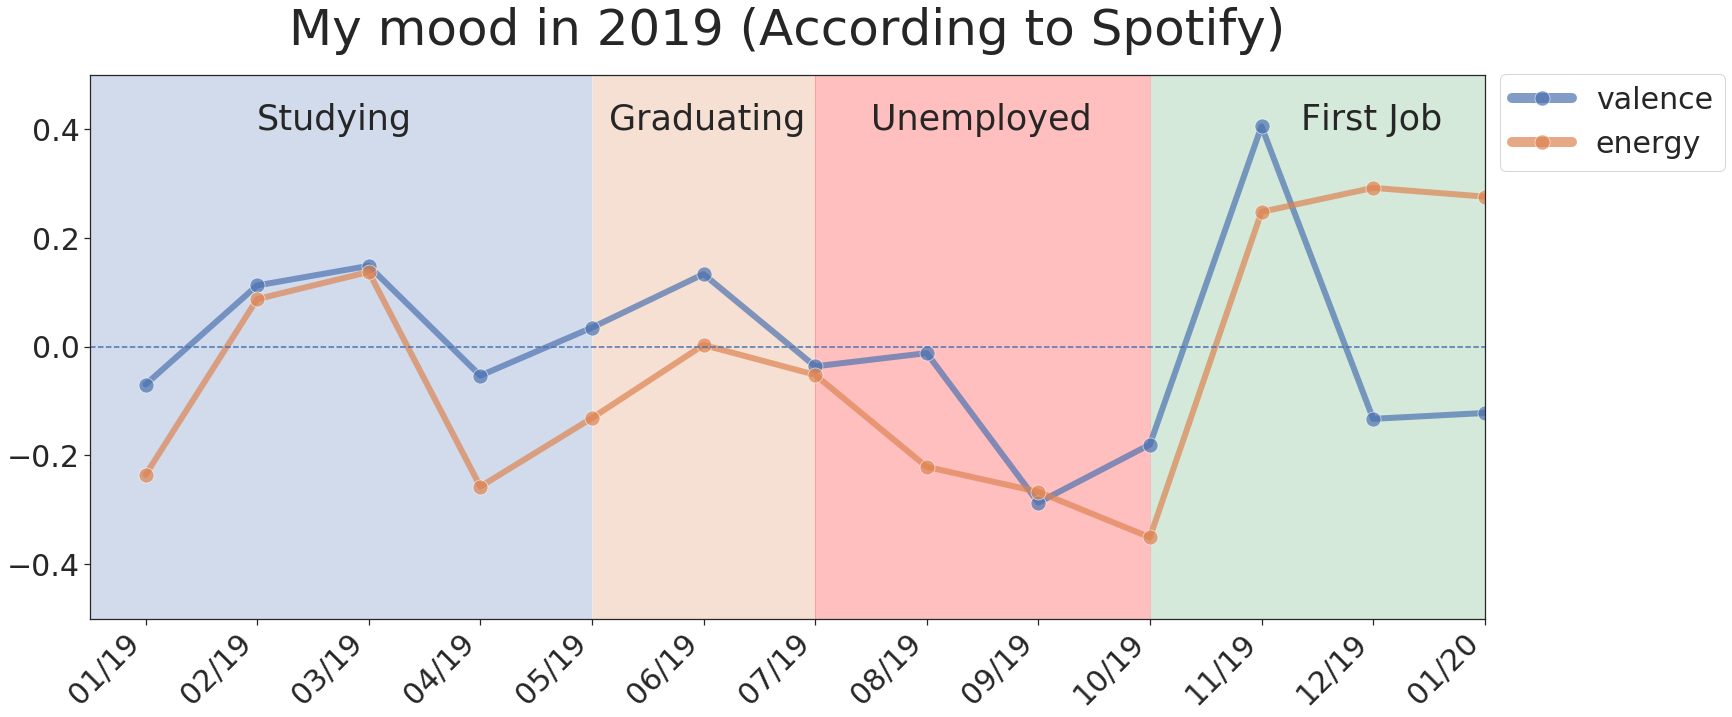

In [66]:
features_sns(['valence', 'energy'])
x = [-1] + [x for x in range(13)]
alpha = .25
plt.ylim([-.5, .5])
plt.xlim([-.5, 12])

plt.fill_between(x[:6], -.5, 0.5, alpha=alpha)
plt.fill_between(x[5:8], -.5, 0.5, alpha=alpha)
plt.fill_between(x[7:11], -.5, 0.5, alpha=alpha, color="red")
plt.fill_between(x[10:], -.5, 0.5, alpha=alpha)

plt.annotate('Studying', (1, 0.4), size=35)
plt.annotate('Graduating', (4.15, 0.4), size=35,)
plt.annotate('Unemployed', (6.5, 0.4), size=35,)
plt.annotate('First Job', (10.35, 0.4), size=35,)

plt.axhline(y=0, color='b', linestyle='--')


plt.show()